## 시군구 형식(v1.2)의 모델 학습 및 예측

### 1. 라이브러리 및 Geometric 설정

- 셰이프 데이터: TL_SCCO_SIG.shp
- Grid 데이터: si_gun_gu_allocation_v2.2.csv (특수시군구를 통합한 그리드파일)
  - 컬럼형태: [Row, Column, Region_Name, SIG_ENG_NM, **Ratio (0.0 ~ 1.0)**]

### 2. 모델 학습 코드

### 3. 모델 예측 코드

### 4. 시-군-구 평균 농도 산출 및 데이터 테이블화

---

### 라이브러리 및 Geometric 설정

시군구 격자 CSV 로드 완료: 1589개 격자
Shapefile 기반 격자 생성 완료: 1181개 격자

최종 통합 격자 정보 생성 완료: 1589개 격자
영토 마스크 생성 완료. 마스크 내 활성 격자 수: 1589


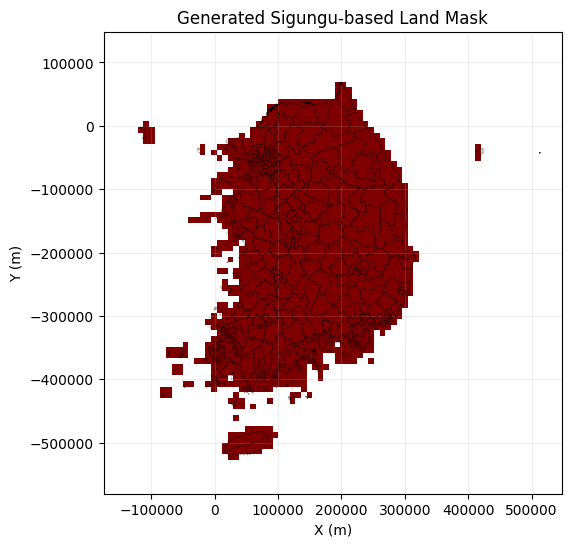

In [3]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/')

# 모델 라이브러리
from src.model.cmaqnet_cond_unet_SIG_v2 import build_model

# 학습 및 처리/분석 관련 라이브러리
import numpy as np
import pandas as pd
import netCDF4 as nc
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Geometric 및 시각화 라이브러리
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# 2D Map 결과 도출을 위한 좌표계 설정
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

def get_sigungu_map() -> gpd.GeoDataFrame:
    """시군구 단위의 shapefile을 로드하는 함수"""
    # 시군구 단위 Shapefile 경로
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/TL_SCCO_SIG.shp'
    sigungu_map = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    sigungu_map.crs = 'EPSG:5179'
    return sigungu_map

def get_base_raster() -> gpd.GeoDataFrame:
    """시뮬레이션 영역에 대한 82x67 베이스 격자망을 포인트 형태로 생성하는 함수"""
    points = [Point(i, j)
              for i in range(-180000, -180000 + 9000 * 67, 9000)
              for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = proj # 좌표계 설정
    grid_data['index'] = grid_data.index
    return grid_data

def create_sigungu_grid_and_mask() -> (pd.DataFrame, np.ndarray):
    """
    시군구 단위의 GRID CSV와 Shapefile을 통합하여
    최종 격자 할당 정보(DataFrame)와 영토 마스크(Numpy Array)를 생성합니다.
    """
    # 1. 시군구 단위 격자 할당 CSV 파일 로드 (우선순위 데이터)
    try:
        # 이전에 변환한 v2 CSV 파일을 사용합니다.
        univ_grid = (
            pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/si_gun_gu_allocation_v2.2.csv')
            .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False])
            .drop_duplicates(subset=['Row', 'Column'], keep='first')
            .reset_index(drop=True)
        )
        univ_grid = univ_grid[['Row', 'Column', 'Region_Name', 'SIG_ENG_NM']].copy()
        print(f"시군구 격자 CSV 로드 완료: {len(univ_grid)}개 격자")
    except FileNotFoundError:
        print("경고: si_gun_gu_allocation_v2.csv 파일을 찾을 수 없습니다.")
        univ_grid = pd.DataFrame(columns=['Row', 'Column', 'Region_Name', 'SIG_ENG_NM'])

    # 2. Shapefile 기반의 격자 정보 생성 (보조 데이터)
    sigungu_map = get_sigungu_map()
    grid_data = get_base_raster()
    sido_code_map = {
        '11': 'Seoul', '26': 'Busan', '27': 'Daegu', '28': 'Incheon',
        '29': 'Gwangju', '30': 'Daejeon', '31': 'Ulsan', '36': 'Sejong',
        '41': 'Gyeonggi', '42': 'Gangwon', '43': 'Chungbuk', '44': 'Chung-Nam',
        '45': 'Jeon-Buk', '46': 'Jeon-Nam', '47': 'Gyeong-Buk', '48': 'Gyeong-Nam',
        '50': 'Jeju'
    }
    joined_gdf = gpd.sjoin(grid_data, sigungu_map.to_crs(grid_data.crs), how='left', predicate='within')
    valid_grids = joined_gdf.dropna(subset=['SIG_CD']).copy()
    valid_grids['Row'] = (valid_grids['index'] % 82) + 1
    valid_grids['Column'] = (valid_grids['index'] // 82) + 1
    valid_grids['Region_Name'] = valid_grids['SIG_CD'].str[:2].map(sido_code_map)
    gov_grid = valid_grids[['Row', 'Column', 'Region_Name', 'SIG_ENG_NM']]
    print(f"Shapefile 기반 격자 생성 완료: {len(gov_grid)}개 격자")

    # 3. 두 데이터 소스를 통합하여 최종 격자 할당 정보(grid_alloc) 생성
    grid_alloc = (
        pd.concat([univ_grid, gov_grid])
        .drop_duplicates(subset=['Row', 'Column'], keep='first')
        .reset_index(drop=True)
    )
    print(f"\n최종 통합 격자 정보 생성 완료: {len(grid_alloc)}개 격자")

    # 4. 영토 마스크(mask) 생성
    # Numpy 인덱싱을 위해 좌표를 1-based에서 0-based로 조정
    grid_alloc_for_mask = grid_alloc.copy()
    grid_alloc_for_mask[['Row', 'Column']] = grid_alloc_for_mask[['Row', 'Column']] - 1
    
    # 행, 열 인덱스 추출
    row_indices = grid_alloc_for_mask['Row'].values
    col_indices = grid_alloc_for_mask['Column'].values
    
    # 82x67 크기의 빈 마스크를 만들고, 영토에 해당하는 부분만 1로 채움
    mask = np.zeros((82, 67))
    mask[row_indices, col_indices] = 1
    print(f"영토 마스크 생성 완료. 마스크 내 활성 격자 수: {int(np.sum(mask))}")
    
    return grid_alloc, mask

# --- 메인 코드 실행 ---
# 시군구 기반의 최종 격자 정보와 영토 마스크를 생성합니다.
grid_alloc, mask = create_sigungu_grid_and_mask()

# 지도 시각화를 위한 설정
sigungu_map = get_sigungu_map()
sigungu_map_proj = sigungu_map.to_crs(proj)
offset_x, offset_y = 4500, 4500

# 생성된 마스크 시각화
fig, ax = plt.subplots(figsize=(7, 6))
cmap_white = mpl.colormaps['jet'].copy()
cmap_white.set_under('white')

im = ax.imshow(mask[::-1], cmap=cmap_white, vmin=0.1, 
               extent=(-180000 + offset_x, 414000 + offset_x, -585000 + offset_y, 144000 + offset_y))
sigungu_map_proj.boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, alpha=0.3)
ax.set_title("Generated Sigungu-based Land Mask")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
plt.grid(alpha=0.2)
plt.show()

### 모델 학습 코드

In [4]:
# 입력 데이터셋 로드
emis_ctrl_2019_05 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
# emis_ctrl_2019_05['Timestep'] = 0.0 # 추후에 Boundary/Time Embedding 동시 수행 관점에서 사용
emis_ctrl_2019_05['Boundary'] = 0.5
emis_ctrl_2019_10 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([
    emis_ctrl_2019_05,
    emis_ctrl_2019_10
], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]
# 레이블 데이터 로드
base_path_2019 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2019'
conc_path = []
for i in range(1, 120): conc_path.append(os.path.join(base_path_2019, '0.50', f'ACONC.{i}'))
for i in range(1, 120): conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))
conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['PM2_5'][:].data.squeeze())
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [5]:
# 모델 학습 시 저장 경로
model_path = '/home/user/workdir/CMAQ_Emulator/main/src/model/pm25_prediction/PM25_MODEL_SIG_v1.2'

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 32  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed, stratify=boundary_data)

# Cosine Decay 스케줄 설정
steps_per_epoch = len(X_emis_train) // batch_size 
total_steps = epochs * steps_per_epoch

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3,
        decay_steps=total_steps,
        alpha=0.1  # 최종 lr 비율 (0이면 최솟값이 0)
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[128],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[128, 96],
        hidden_depth=4,
        in_filters=20,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=optimizer, 
        loss=tf.keras.losses.Huber(delta=1)  # delta는 Huber 손실 전환점
    )

early_stop = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)
history = model.fit(
    x=[X_emis_train, X_boundary_train],
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test],
    callbacks=[early_stop]
)

model.save(model_path)

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'Optional' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'Optional' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/pm25_prediction/PM25_MODEL_SIG_v1.2/assets


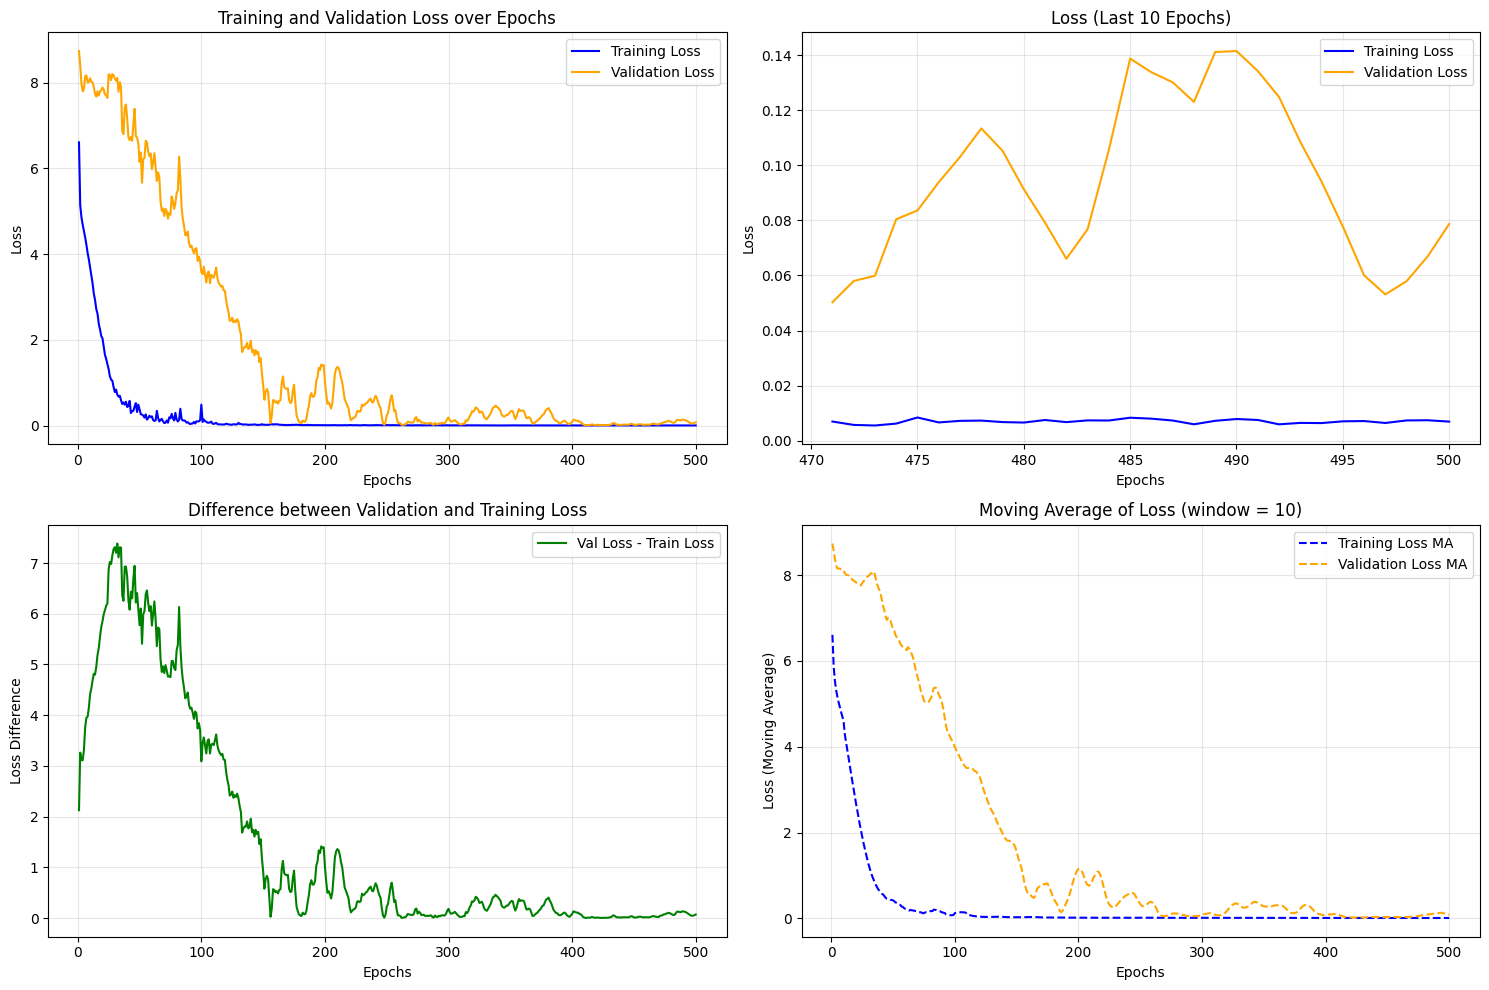

In [6]:
def plot_loss(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # 1. 전체 에포크에 대한 학습 및 검증 손실
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. 마지막 10 에포크의 손실 (세부 분석)
    plt.subplot(2, 2, 2)
    if len(epochs) >= 30:
        last_epochs = epochs[-30:]
        plt.plot(last_epochs, history.history['loss'][-30:], label='Training Loss', color='blue')
        plt.plot(last_epochs, history.history['val_loss'][-30:], label='Validation Loss', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss (Last 10 Epochs)')
        plt.legend()
        plt.grid(alpha=0.3)
    else:
        plt.text(0.5, 0.5, "Not enough epochs for zoomed plot", ha='center')
    
    # 3. 학습 손실과 검증 손실의 차이
    plt.subplot(2, 2, 3)
    loss_diff = np.array(history.history['val_loss']) - np.array(history.history['loss'])
    plt.plot(epochs, loss_diff, label='Val Loss - Train Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Difference')
    plt.title('Difference between Validation and Training Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 4. 이동 평균 (window=10)을 통한 평활화된 손실 추세
    plt.subplot(2, 2, 4)
    window = 10
    if len(epochs) >= window:
        train_ma = [np.mean(history.history['loss'][max(0, i-window):i]) for i in range(1, len(history.history['loss'])+1)]
        val_ma = [np.mean(history.history['val_loss'][max(0, i-window):i]) for i in range(1, len(history.history['val_loss'])+1)]
        plt.plot(epochs, train_ma, label='Training Loss MA', color='blue', linestyle='--')
        plt.plot(epochs, val_ma, label='Validation Loss MA', color='orange', linestyle='--')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Moving Average)')
        plt.title('Moving Average of Loss (window = 10)')
        plt.legend()
        plt.grid(alpha=0.3)
    else:
        plt.text(0.5, 0.5, "Not enough epochs for moving average plot", ha='center')
    
    plt.tight_layout()
    plt.show()

# Loss 결과물 출력
plot_loss(history)

### 모델 예측 코드

In [7]:
test_split = 0.2  # 테스트 데이터 스플릿 비율 (20%)
random_seed = 42  # 랜덤 시드

# GPU를 이용한 추론 작업 셋팅
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)
strategy = tf.distribute.MirroredStrategy()

# 0. 학습된 Local AQM 모델 로드
with strategy.scope():
    model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/pm25_prediction/PM25_MODEL_SIG_v1.2')

# 1. 입력 데이터셋 (지역별 전구물질 배출량, 17x5 크기 데이터, 총 119개 시나리오의) 로드
emis_ctrl_2019_05 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019.csv', index_col=0)

# 2. 국외 영향 Factor인 BC의 값을 0.5, 1.0로 균등하게 샘플링
emis_ctrl_2019_05['Boundary'] = 0.5
emis_ctrl_2019_10 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_10['Boundary'] = 1.0
ctrl_data = pd.concat([
    emis_ctrl_2019_05,
    emis_ctrl_2019_10
], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

# 입력 1: pred_emis_data 지역별 배출량 (85x1), 입력 2: pred_boundary_data BC 값 (1x1)
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]

# 레이블 데이터 로드 (레이블: CMAQ 시뮬레이션 데이터, 추후 예측 결과 성능 검증에 사용)
base_path_2019 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2019'
conc_path = []
for i in range(1, 120): conc_path.append(os.path.join(base_path_2019, '0.50', f'ACONC.{i}'))
for i in range(1, 120): conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))
conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['PM2_5'][:].data.squeeze())
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

# 4. Local AQM 모델의 입력 데이터, 레이블 데이터 셋업 완료
_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed, stratify=pred_boundary_data)

# 5. Local AQM 모델을 이용한 추론 진행
y_preds = model.predict([X_emis_test,  X_boundary_test])
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()
print("y_pred:", y_pred.shape, "y_true:", y_true.shape)

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2/2 [==============================] - 4s 411ms/step
y_pred: (48, 82, 67) y_true: (48, 82, 67)


In [8]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)
pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용

In [9]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=100, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    # y_err_std = np.std(y_norm_err, axis=1)  # (48,)
    return y_err_mean, y_err_std

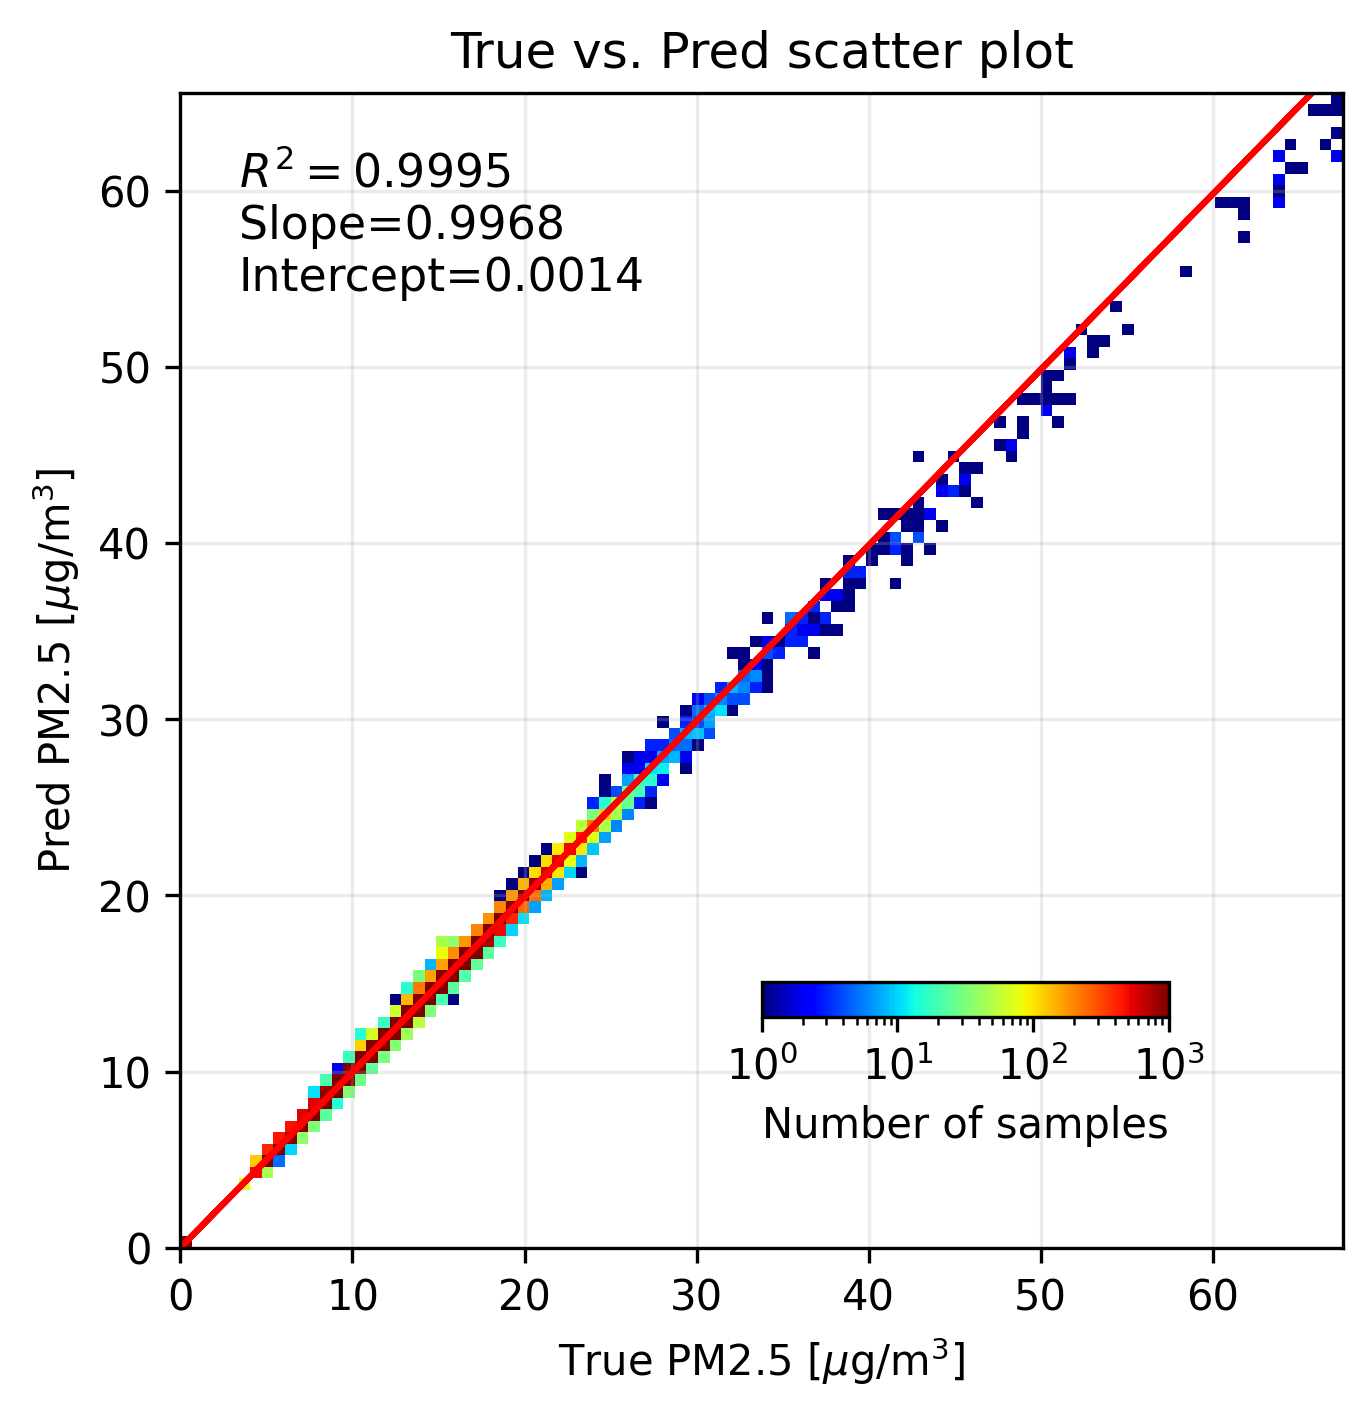

In [10]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

# y_true_modi = y_true.reshape(-1)
# y_pred_modi = y_pred.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True PM2.5 [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred PM2.5 [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

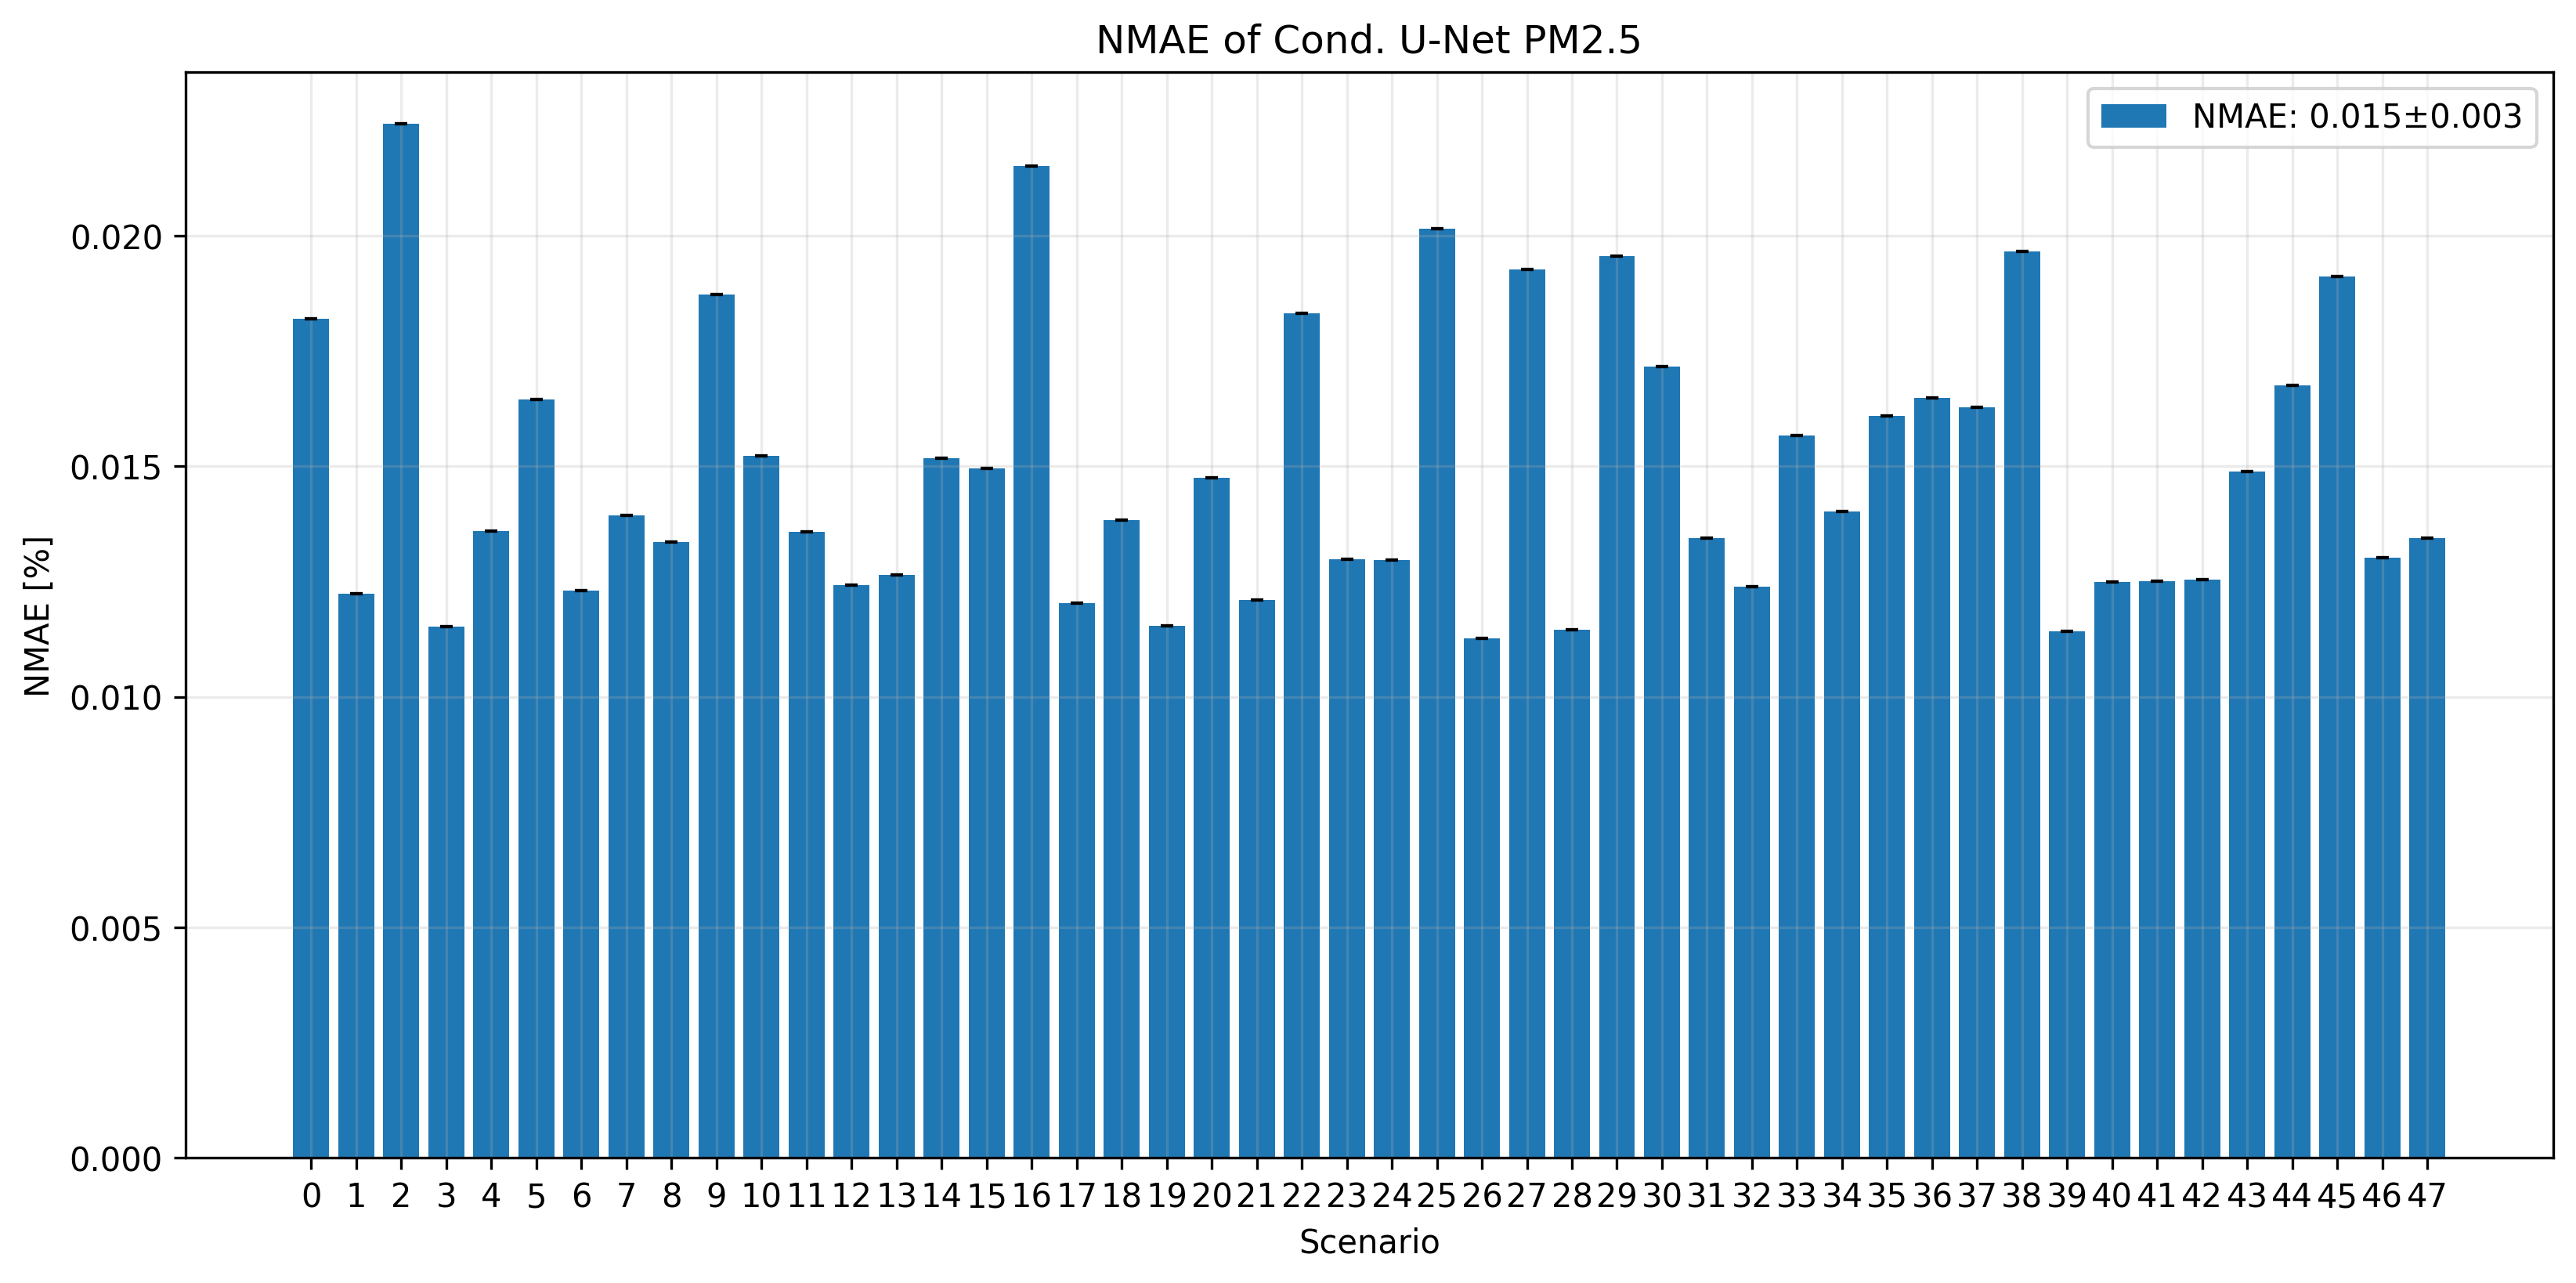

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
# score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net PM2.5")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

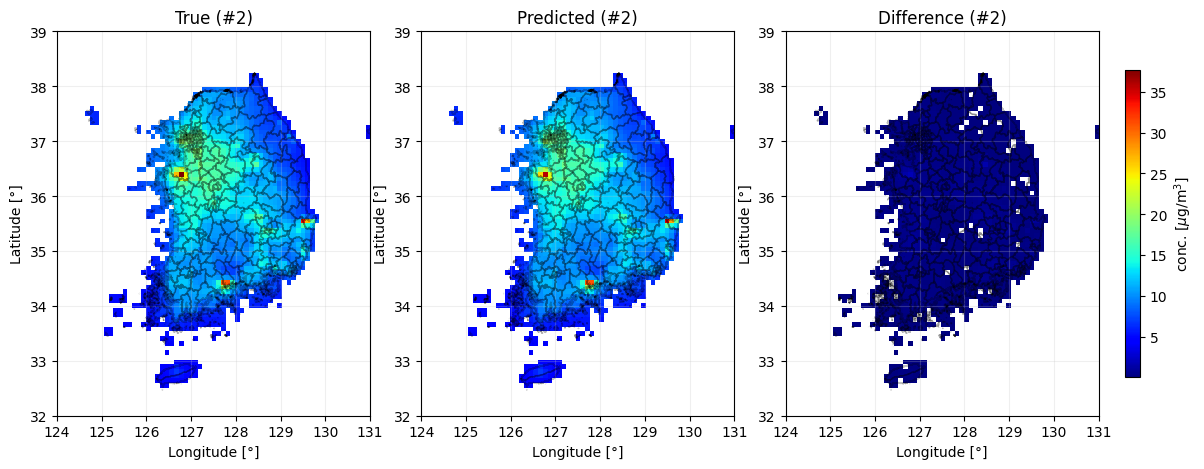

In [13]:
cmap_with_white = plt.get_cmap('jet').copy()   # jet 컬러맵 복사
cmap_with_white.set_bad('white')               # 마스킹된 부분을 흰색으로

def plot_prediction_loss(y_true, y_pred, map_boundary, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        indices = [indices]
    
    local_min = min(y_true[indices].min(), y_pred[indices].min())
    local_max = max(y_true[indices].max(), y_pred[indices].max())
    local_diff = np.abs(y_true[indices] - y_pred[indices])
    local_max = max(local_max, local_diff.max())

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes[np.newaxis, :]

    x_min, x_max = -180000 + offset_x, 414000 + offset_x
    y_min, y_max = -585000 + offset_y, 144000 + offset_y
    x_ticks, x_labels = np.linspace(x_min, x_max, 8), [str(i) for i in range(124, 132)]
    y_ticks, y_labels = np.linspace(y_min, y_max, 8), [str(i) for i in range(32, 40)]
    threshold = 0.01

    for i, idx in enumerate(indices):
        # (A) True
        data_true = y_true[idx][::-1]
        masked_true = np.ma.masked_where(data_true <= threshold, data_true)
        im_true = axes[i, 0].imshow(masked_true, cmap=cmap_with_white, extent=(x_min, x_max, y_min, y_max), vmin=threshold, vmax=local_max)
        # ctprvn_proj 대신 인자로 받은 map_boundary 사용
        map_boundary.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_xlim(x_min, x_max)
        axes[i, 0].set_ylim(y_min, y_max)
        axes[i, 0].set_xticks(x_ticks)
        axes[i, 0].set_yticks(y_ticks)
        axes[i, 0].set_xticklabels(x_labels)
        axes[i, 0].set_yticklabels(y_labels)
        axes[i, 0].grid(alpha=0.25, color='silver')

        # (B) Predicted
        data_pred = y_pred[idx][::-1]
        masked_pred = np.ma.masked_where(data_pred <= threshold, data_pred)
        im_pred = axes[i, 1].imshow(masked_pred, cmap=cmap_with_white, extent=(x_min, x_max, y_min, y_max), vmin=threshold, vmax=local_max)
        # ctprvn_proj 대신 인자로 받은 map_boundary 사용
        map_boundary.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_xlim(x_min, x_max)
        axes[i, 1].set_ylim(y_min, y_max)
        axes[i, 1].set_xticks(x_ticks)
        axes[i, 1].set_yticks(y_ticks)
        axes[i, 1].set_xticklabels(x_labels)
        axes[i, 1].set_yticklabels(y_labels)
        axes[i, 1].grid(alpha=0.25, color='silver')

        # (C) Difference
        data_diff = np.abs(y_true[idx] - y_pred[idx])[::-1]
        masked_diff = np.ma.masked_where(data_diff <= threshold, data_diff)
        im_diff = axes[i, 2].imshow(masked_diff, cmap=cmap_with_white, extent=(x_min, x_max, y_min, y_max), vmin=threshold, vmax=local_max)
        # ctprvn_proj 대신 인자로 받은 map_boundary 사용
        map_boundary.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_xlim(x_min, x_max)
        axes[i, 2].set_ylim(y_min, y_max)
        axes[i, 2].set_xticks(x_ticks)
        axes[i, 2].set_yticks(y_ticks)
        axes[i, 2].set_xticklabels(x_labels)
        axes[i, 2].set_yticklabels(y_labels)
        axes[i, 2].grid(alpha=0.25, color='silver')

    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.tight_layout(rect=[0, 0, 0.88, 0.96])
    cbar = fig.colorbar(im_true, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.03, pad=0.02, shrink=0.8)
    cbar.set_label('conc. [$\\mu \\mathrm{g}/\\mathrm{m}^3$]')
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, sigungu_map_proj, indices=np.argmax(score))

### 시-군-구 평균 농도 산출 및 데이터 테이블화

In [ ]:
# 1. A~Q 순서에 해당하는 광역지자체 이름 리스트 생성
region_columns = {
    'A': 'Seoul', 'B': 'Incheon', 'C': 'Busan', 'D': 'Daegu',
    'E': 'Gwangju', 'F': 'Gyeonggi', 'G': 'Gangwon', 'H': 'Chungbuk',
    'I': 'Chung-Nam', 'J': 'Gyeong-Buk', 'K': 'Gyeong-Nam', 'L': 'Jeon-Buk',
    'M': 'Jeon-Nam', 'N': 'Jeju', 'O': 'Daejeon', 'P': 'Ulsan', 'Q': 'Sejong'
}
region_order = list(region_columns.values())

# 2. 테스트 데이터셋 전체 기간에 대한 평균 농도 계산
avg_true_conc = np.mean(y_true, axis=0)
avg_pred_conc = np.mean(y_pred, axis=0)

# 3. 격자별 농도 데이터를 시군구 정보와 결합
grid_data_list = []
for _, row in grid_alloc.iterrows():
    r_idx, c_idx = int(row['Row']) - 1, int(row['Column']) - 1
    grid_data_list.append({
        'Region_Name': row['Region_Name'],
        'SIG_ENG_NM': row['SIG_ENG_NM'],
        'True_Conc': avg_true_conc[r_idx, c_idx],
        'Pred_Conc': avg_pred_conc[r_idx, c_idx]
    })
conc_by_grid_df = pd.DataFrame(grid_data_list)

# 4. 시군구를 기준으로 그룹화하여 평균 농도 산출
sigungu_avg_conc_df = conc_by_grid_df.groupby(['Region_Name', 'SIG_ENG_NM']).mean().reset_index()

# 5. 예측 농도와 실제 농도의 차이(Difference) 계산
sigungu_avg_conc_df['Difference'] = sigungu_avg_conc_df['Pred_Conc'] - sigungu_avg_conc_df['True_Conc']

# 6. 보기 쉽게 컬럼 이름 변경
sigungu_avg_conc_df = sigungu_avg_conc_df.rename(columns={
    'True_Conc': 'True_Avg_PM2.5',
    'Pred_Conc': 'Pred_Avg_PM2.5',
    'Difference': 'Difference (Pred - True)'
})

# 7. 광역지자체 A-Q 순서로 정렬하여 결과 테이블 출력
# 'Region_Name' 컬럼을 위에서 정의한 순서를 따르는 Categorical 타입으로 변환합니다.
sigungu_avg_conc_df['Region_Name'] = pd.Categorical(
    sigungu_avg_conc_df['Region_Name'],
    categories=region_order,
    ordered=True
)

# 지정된 광역지자체 순서와 기초지자체 이름 순으로 정렬합니다.
final_sorted_df = sigungu_avg_conc_df.sort_values(by=['Region_Name', 'SIG_ENG_NM']).reset_index(drop=True)

display(final_sorted_df)

# display 결과를 "SIG_table_v1.2.csv" 파일로 저장
final_sorted_df.to_csv("/home/user/workdir/CMAQ_Emulator/main/resources/geom/SIG_table_v1.2.csv", index=False)

,Region_Name,SIG_ENG_NM,True_Avg_PM2.5,Pred_Avg_PM2.5,Difference (Pred - True)
0,Seoul,Jongno-gu,19.134909,19.146530,0.011621
1,Seoul,Nowon-gu,20.400839,20.321712,-0.079126
2,Seoul,Songpa-gu,20.653564,20.448381,-0.205183
3,Seoul,Yeongdeungpo-gu,21.257971,21.013956,-0.244015
4,Seoul,Yongsan-gu,20.594492,20.395575,-0.198917
...,...,...,...,...,...
183,Ulsan,"Buk-gu, Ulsan",13.216816,13.161787,-0.055029
184,Ulsan,"Dong-gu, Ulsan",10.370206,10.431406,0.061200
185,Ulsan,"Nam-gu, Ulsan",14.227098,14.303264,0.076166
186,Ulsan,Ulju-gun,13.491662,13.420786,-0.070876
